<a href="https://colab.research.google.com/github/Tbharvesh/DeepLearning/blob/main/RNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicting Covid-19 Cases Using RNN GRU Model**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


from tensorflow.keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [10]:
dataset = pd.read_csv("/complete.csv")

In [11]:
dataset.head()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


In [12]:
# Extracting date and total confirmed cases columns
date_column = 'Date'
confirmed_cases_column = 'Total Confirmed cases'

# Selecting only the columns of interest
main_dataset = dataset[[date_column, confirmed_cases_column]]

print(main_dataset)

            Date  Total Confirmed cases
0     2020-01-30                    1.0
1     2020-01-31                    1.0
2     2020-02-01                    2.0
3     2020-02-02                    3.0
4     2020-02-03                    3.0
...          ...                    ...
4687  2020-08-06                73050.0
4688  2020-08-06                 5725.0
4689  2020-08-06               104388.0
4690  2020-08-06                 8254.0
4691  2020-08-06                83800.0

[4692 rows x 2 columns]


In [13]:
main_dataset['Total Confirmed cases'] = main_dataset['Total Confirmed cases'].astype(int)

<ipython-input-13-799d83e423cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset['Total Confirmed cases'] = main_dataset['Total Confirmed cases'].astype(int)


In [14]:
# Timeseries componeent is Date ,therefore it is considered as index here --> which is used to locate any column
main_dataset = main_dataset.rename(columns={'Total Confirmed cases': 'Cases'})

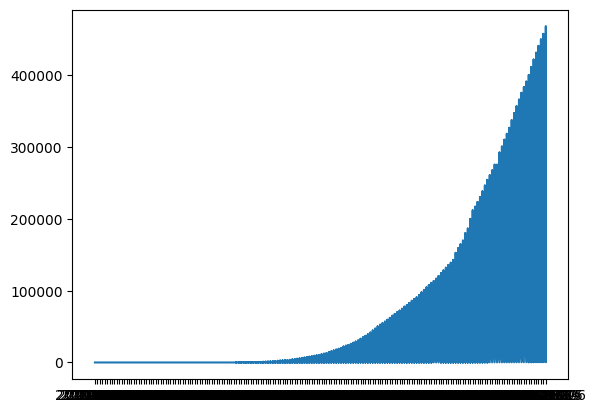

In [15]:
plt.plot(main_dataset.Date,main_dataset.Cases)
plt.show()

## Data Preprocessing

At every point we are taking moving avg

Moving avg= (sum of all the items till n)/n

Exponential moving avg = with every val a factor is multiplied -->If we are at kth instance the value at k-1 is most impotant other than the previous data

Exponential moving avg is calculated as:

1.5*0.5 + 3*0.5 =2.25

2.25*0.5 + 3*0.5 = 2.62

In [16]:
dataset = main_dataset #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['Cases'] #We will be left with only one column Cases for our dataset

In [17]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Cases_MA2']=dataset.expanding(min_periods=3).mean()  #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average.

In [18]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average

In [20]:
dataset = dataset[dataset['Cases_MA2'].notna()] #Remove the rows that have NAs
dataset.head()


,Cases,Cases_MA2,EMA
Date,,,
2020-02-01,2,1.333333,1.50000
2020-02-02,3,1.750000,2.25000
2020-02-03,3,2.000000,2.62500
2020-02-04,3,2.166667,2.81250
2020-02-05,3,2.285714,2.90625


In [21]:
#Cases is the column we have to predict.
target=dataset[['Cases']]
del dataset['Cases']

In [22]:
x, y = dataset.values, target.values

In [23]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1)) #Fit to data and transform the data array y. Reshape the y variable to long format

In [24]:
X_train_data=X[0:4000,]
y_train_data=Y[0:4000,]
X_test_data=X[4000:4690,]
y_test_data=Y[4000:4690,]

In [25]:
X_train_data = X_train_data.reshape((-1,1,2)) #we are processing one row two cols at a time
X_test_data = X_test_data.reshape((-1,1,2))

GRU :

In [26]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer.


In [27]:
GRU_model.compile(loss='mse', optimizer='adam', metrics = ['accuracy']) #mse is mean square error which is the loss function and Adam optimizer will be the ooptimizer.